## Assignment 10

# Development of a tracking filter of a moving object when measurements and motion models are in different coordinate systems

**Starodumova P., Antonov A., Babaev N., Krivova V. | Skoltech EDP course by Tatiana Podladchikova, 2020**

**The objective of Assignment 10 is to develop a tracking filter of a moving object when measurements and motion model are in different coordinate systems. This problem is typical for radio navigation systems. Important outcome of this exercise is to detect main difficulties of practical Kalman filter implementation related with instability zone of a tracking filter, and to analyze conditions under which navigation system may become blind and filter diverges. This is important to prevent collisions and for other safety issues.**

In [37]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.stats import pearsonr

### Instability zone of a tracking filter due to ill-conditioned coordinate transformations of measurements.

**We introduce initial conditions for true trajectory, measurements and Kalman filter algorithm:**

In [5]:
# Initial interval between measurements 
T = 2

# Size of trajectory
size = 26

# Variances of measurement noises
sigmaD = 20
sigmaAng = 0.02

# Initial coordinates
initialX = np.matrix([[13500/(2)**0.5],
                      [-50],
                      [13500/(2)**0.5],
                      [-45]])

# Initial filtered estimate of state vector
initialXK = np.matrix([[40000],[-20],[40000],[-20]])

# Initial filtration error covariance matrix
initialPK = np.matrix([[10**10,0,0,0],
                       [0,10**10,0,0],
                       [0,0,10**10,0],
                       [0,0,0,10**10]])

# Transition matrix
Phi = np.matrix([[1,T,0,0],
                 [0,1,0,0],
                 [0,0,1,T],
                 [0,0,0,1]])

# Observation matrix
H = np.matrix([[1,0,0,0],
               [0,0,1,0]])

**Some secondary functions to develop Kalman filter algorithm and plot graphs:**

In [81]:
# Plot graphs

def showPlease(arr,legend = [],xlabel ="x",ylabel="y",title="title"):
    params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    max_len = 0
    for i in arr:
        if(len(i) > max_len):
            max_len = len(i)
    for i in arr:
        if(len(i) == max_len):
            plt.plot(i)
        else:
            plt.plot([j for j in range(max_len - len(i),max_len)],i)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    plt.grid()
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    plt.legend(legend, fontsize = 16)
    plt.title(title, fontsize = 16);
    plt.show()

In [7]:
# Return a vector

def vector(x):
    v = []
    for i in x:
        v.append([i])
    return np.matrix(v)

In [8]:
# Return an array of elements 

def giveElements(vectors,index):
    x = []
    for i in range(0,len(vectors)):
        x.append((vectors[i][index].item(0)))
    return x

**Then, we define a function which returns navigation parameters — range D and azimuth $\beta$ (polar coordinate system):**

In [9]:
def polar(x,y):
    D = (x**2+y**2)**0.5
    ang = np.arctan(x/y)
    return D,ang

**as well as a function which transforms them into Cartesian coordinate system:**

In [10]:
def cor(D,ang):
    x = D*np.sin(ang)
    y = D*np.cos(ang)
    return x,y

**The following function returns a true trajectory of an object that moves uniformly (deterministic case, as no random disturbance affect a motion) in both polar and Cartesian coordinate systems:**

In [11]:
def motion(data):
    X = data.initialVectorX
    T = data.T
    size = data.size
    Vx = X.item(1,0)
    Vy = X.item(3,0)
    processCor = [X.copy()]
    D,ang = polar(X.item(0,0),X.item(2,0))
    processPol = [vector([D,ang])]
    for i in range(1,size):
        x = processCor[-1].item(0,0) + processCor[-1].item(1,0)*T
        y = processCor[-1].item(2,0) + processCor[-1].item(3,0)*T
        processCor.append(vector([x,Vx,y,Vy]))
        D,ang = polar(x,y)
        processPol.append(vector([D,ang]))
    data.trueProcess = copy.deepcopy(processCor)
    data.trueProcessPol = copy.deepcopy(processPol)
    return processCor,processPol

**This function returns measurements of navigation parameters in polar coordinate system:**

In [12]:
def measPol(data):
    meas = copy.deepcopy(data.trueProcessPol)
    sigmaD = data.externalNoiseSigma[0]
    sigmaAng = data.externalNoiseSigma[1]
    for i in range(0,len(meas)):
        meas[i][0] = meas[i][0] + np.random.normal(0,sigmaD)
        meas[i][1] = meas[i][1] + np.random.normal(0,sigmaAng)
    data.measPol = copy.deepcopy(meas)
    return meas  

**and this one — in Cartesian coordinate system:**

In [13]:
def pseudoMeas(data):
    processPol = copy.deepcopy(data.measPol)
    meas = []
    for i in processPol:
        x,y = cor(i.item(0,0),i.item(1,0))
        meas.append(vector([x,y]))
    data.measProcess = copy.deepcopy(meas)
    return meas

In [14]:
# !!!!!!!!!!!! no idea why we need it
def addV(pseudoMeas):
    for i in range(0,len(pseudoMeas)):
        x = pseudoMeas[i].item(0,0)
        y = pseudoMeas[i].item(1,0)
        pseudoMeas[i] = np.matrix([[x],[0],[y],[0]])

**Here we introduce the class to develop covariance matrix of measurement error R:**

In [15]:
class Data:
    def __init__(self, initialVectorX,F = None, H = None, G = None,initialVectorXK = None, initialMatrixP = None, 
                 externalNoiseSigma = None,typeOfProcess = "usual", optimalK = None,size = None,T = 2,amount = 500):
        self.F = copy.deepcopy(F)
        self.H = copy.deepcopy(H)
        self.G = copy.deepcopy(G)
        self.T = T
        self.Q = 0 if typeOfProcess == "det" else self.G*self.G.T*(internalNoiseSigma**2)

        self.initialVectorX = copy.deepcopy(initialVectorX)
        self.initialVectorXK = initialVectorXK.copy() if initialVectorXK is not None else None
        self.initialMatrixP = copy.deepcopy(initialMatrixP)

        self.externalNoiseSigma = copy.deepcopy(externalNoiseSigma)

        self.optimalK = copy.deepcopy(optimalK)

        self.typeOfProcess = typeOfProcess
        self.amount = amount
        
        self.size = size
        
    def calculateR(self):
        measPol = self.measPol
        self.listR = []
        sigmaDSq = (self.externalNoiseSigma[0])**2
        sigmaAngSq = (self.externalNoiseSigma[1])**2
        for i in range(0,len(measPol)):
            D = measPol[i].item(0,0)
            ang = measPol[i].item(1,0)
            r00 = (np.sin(ang))**2*sigmaDSq + D**2*(np.cos(ang))**2*sigmaAngSq
            r01 = np.sin(ang)*np.cos(ang)*(sigmaDSq-D**2*sigmaAngSq)
            r10 = np.sin(ang)*np.cos(ang)*(sigmaDSq-D**2*sigmaAngSq)
            r11 = (np.cos(ang))**2*sigmaDSq + D**2*(np.sin(ang))**2*sigmaAngSq
            R = np.matrix([[r00,r01],[r10,r11]])
            self.listR.append(R)

**and the class to develop Kalman filter algorithm in order to estimate state vector — at every extrapolation and filtration, step range D and azimuth $\beta$ are calculated using extrapolated and filtered estimates:**

In [16]:
class KalmanFilter:
    def __init__(self,dataForKalman):
        self.dataForKalman = dataForKalman
        self.kalmanVectors = None
        self.listK = None
        self.listP = None
        self.length = len(self.dataForKalman.trueProcess)
        
    def calculateKalmanVectors(self):
        self.kalmanVectors = []
        self.kalmanVectorsPr = []
        self.listK = []
        self.listP = []
        self.listPtr = []
        prevX = copy.deepcopy(self.dataForKalman.initialVectorXK)
        prevP = copy.deepcopy(self.dataForKalman.initialMatrixP.copy())
        if(self.dataForKalman.optimalK is not None):
            K = dataForKalman.optimalK
            for i in range(0,self.length):
                predictedX,predictedP = self.predict(prevX,prevP)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,i)
                self.listP.append(prevP)
                self.kalmanVectors.append(prevX)
        else:
            for i in range(0,self.length):
                predictedX,predictedP = self.predict(prevX,prevP)
                K = self.calculateK(predictedP,i)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,i)
                self.listP.append(prevP)
                self.kalmanVectors.append(prevX)
        self.calculatePol()
        
    def predict(self,prevX,prevP):
        F = self.dataForKalman.F
        Q = self.dataForKalman.Q
        x = F*prevX
        P = F*prevP*F.T + Q
        self.kalmanVectorsPr.append(x)
        self.listPtr.append(P)
        return x, P
    
    def calculateK(self,predictedP,index):
        H = self.dataForKalman.H
        R = self.dataForKalman.listR[index]
        K = predictedP*H.T*(H*predictedP*H.T + R)**(-1)
        self.listK.append(K)
        return K
    
    def filtrate(self,predictedX,predictedP,K,measIndex):
        H = copy.deepcopy(self.dataForKalman.H)
        meas = self.dataForKalman.measProcess[measIndex].copy()
        x = predictedX + K*(meas - H*predictedX)
        KH = K*H
        P = (np.identity(KH.shape[0]) - KH) * predictedP
        return x,P
    
    def calculatePol(self):
        self.kalmanVectorsPol = []
        self.kalmanVectorsPolPr = []
        for i in self.kalmanVectors:
            D,ang = polar(i.item(0,0),i.item(2,0))
            self.kalmanVectorsPol.append(vector([D,ang]))
        for i in self.kalmanVectorsPr:
            D,ang = polar(i.item(0,0),i.item(2,0))
            self.kalmanVectorsPolPr.append(vector([D,ang]))
    
    def extrapolate(self,step):
        predictions = []
        F = self.dataForKalman.F
        for i in range(step-1,self.length):
            predictions.append((F**(step - 1))*self.kalmanVectors[i - step + 1])
        return predictions
    
    def errors(self,values,index):
        start = 0
        errors = []
        if(len(values) < self.length):
            start = length - len(values)
        for i in range(start,self.length):
            errors.append(self.dataForKalman.trueVectorsOfProcess[i][index][0] - values[i - start ])
        return errors

**Function which runs Kalman algorithm:**

In [17]:
def createProcessGiveKalman(data):
    motion(data)
    measPol(data)
    pseudoMeas(data)
    data.calculateR()
    k = KalmanFilter(data)
    k.calculateKalmanVectors()
    return k

**In order to estimate dynamics of mean-squared error of estimations over observation interval, we introduce a function which calculates true estimation errors of filtered estimates by running Kalman filter over M times:**

In [18]:
def finalErr(l,amount):
        for i in range(0,len(l)):
            l[i] = (l[i]/(amount - 1))**0.5
            
def errorsSq(target,listOfLists,resultListOfLists):
    t = np.array(target)
    for i in range(0,len(listOfLists)):
        l = np.array(listOfLists[i])
        r = 0
        if(len(l) == len(t)):
            r = ((t - l)**2 )
        else:
            r = ((t[len(t) - len(l):] - l)**2 )
        resultListOfLists[i] = resultListOfLists[i] + r      
        
def manyKalman(data):
    shiftsD = [0,0]
    listOflistsD = []
    for i in range(0,len(shiftsD)):
        listOflistsD.append(np.array([0 for j in range(shiftsD[i],data.size)]))
        
    shiftsAng = [0,0]
    listOflistsAng = []
    for i in range(0,len(shiftsAng)):
        listOflistsAng.append(np.array([0 for j in range(shiftsAng[i],data.size)]))
        
    for i in range(0,data.amount):
        kalman = createProcessGiveKalman(data)
        D = giveElements(kalman.kalmanVectorsPol,0)
        Dpr = giveElements(kalman.kalmanVectorsPolPr,0)
        Ang = giveElements(kalman.kalmanVectorsPol,1)
        Angpr = giveElements(kalman.kalmanVectorsPolPr,1)
        errorsSq(giveElements(data.trueProcessPol,0),[D,Dpr],listOflistsD)
        errorsSq(giveElements(data.trueProcessPol,1),[Ang,Angpr],listOflistsAng)
    finalErr(listOflistsD,data.amount)
    finalErr(listOflistsAng,data.amount)
    return listOflistsD,listOflistsAng

**Firstly, we will analize the case when an object starts its motion at a quite great distance from an observer (it can be seen from the initial coordinates which were presented earlier)!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!.**

In [19]:
data = Data(typeOfProcess="det",initialVectorX=initialX,initialVectorXK=initialXK,F = Phi,H = H,size=size,
         initialMatrixP=initialPK, externalNoiseSigma=[sigmaD,sigmaAng])

**Let us run Kalman filter algorithm over M = 500 times in order to calculate true errors of estimation — to be particular, (a) errors of extrapolation and filtration estimates of range D, (b) errors of extrapolation and filtration estimates of azimuth $\beta$:**

In [20]:
data.amount = 500
D_10,Ang_10 = manyKalman(data)

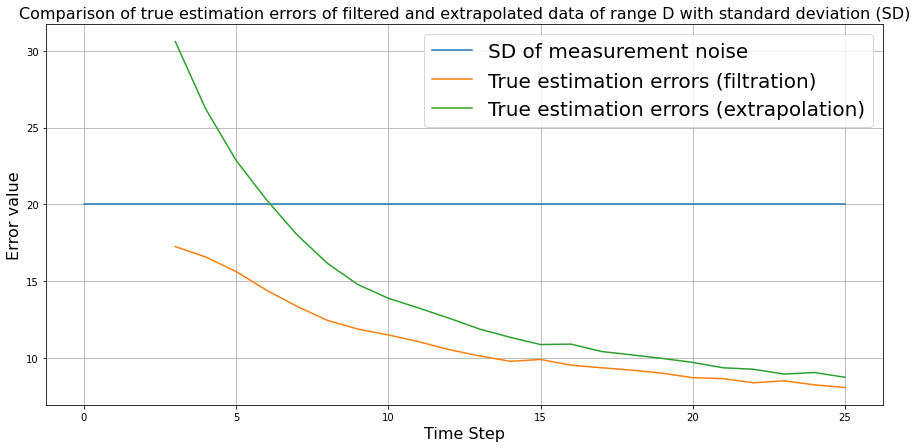

In [28]:
sigmaList = [data.externalNoiseSigma[0] for i in range(0,data.size)]
showPlease([sigmaList,D_10[0][3:],D_10[1][3:]],
           ['SD of measurement noise', 
            'True estimation errors (filtration)', 
            'True estimation errors (extrapolation)'], 
            'Time Step', 'Error value', 
            'Comparison of true estimation errors of filtered and extrapolated data of range D with standard deviation (SD)');

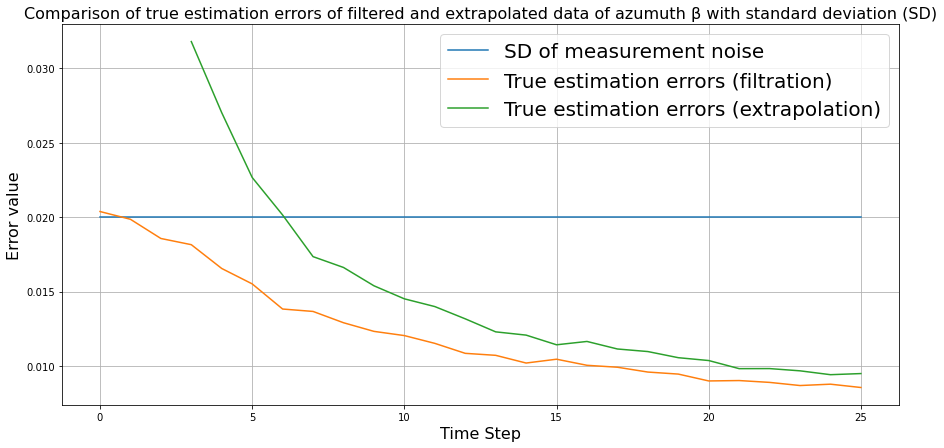

In [29]:
sigmaListAng = [data.externalNoiseSigma[1] for i in range(0,data.size)]
showPlease([sigmaListAng,Ang_10[0],Ang_10[1][3:]],
           ['SD of measurement noise', 
            'True estimation errors (filtration)', 
            'True estimation errors (extrapolation)'], 
            'Time Step', 'Error value', 
            'Comparison of true estimation errors of filtered and extrapolated data of azumuth β with standard deviation (SD)');

**In both cases, for range D and azimuth β, true estimation errors are slightly decreasing with time. The values of true estimation errors at the end of time period are smaller that of standard deviation which means that the filter makes predictions and filtrations with high accuracy.**

In [48]:
kalman = KalmanFilter(data)
kalman.calculateKalmanVectors()

# 11

**Now our measurement model is nonlinear. However, there is a possibility that the model under study is at least close to linear under some specific conditions. Let see what we have for the first case:**

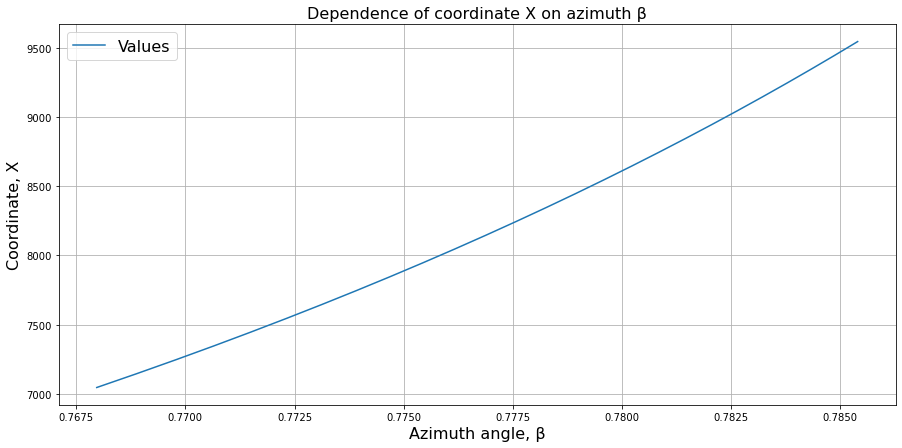

In [39]:
x = giveElements(data.trueProcess,0)
ang = giveElements(data.trueProcessPol,1)

plt.figure(figsize=(15,7))
plt.grid()
plt.xlabel('Azimuth angle, β', fontsize = 16)
plt.ylabel('Coordinate, X', fontsize = 16)
plt.title('Dependence of coordinate X on azimuth β', fontsize = 16)
plt.plot(ang,x)
plt.legend(['Values'], fontsize = 16);

**The graph seems to be quite close to linear, but let us calculate Pearsons correlation coefficient to see how strong the relationship between two variables is.**

In [38]:
# Calculate Pearsons correlation coefficient

corr, _ = pearsonr(ang, x)
print('Pearsons correlation: %.2f' % corr)

Pearsons correlation: 1.00


**Now it is clearly seen that the dependence of coordinate and azimuth angle is highly close to linear, although according to coordinate transformation x and β has nonlinear relation. It means that linearization errors are insignificant in this case.**

**Let us calculate condition number of covariance matrix R over the observation interval:**

In [44]:
condNumbers = [np.linalg.cond(x) for x in data.listR]

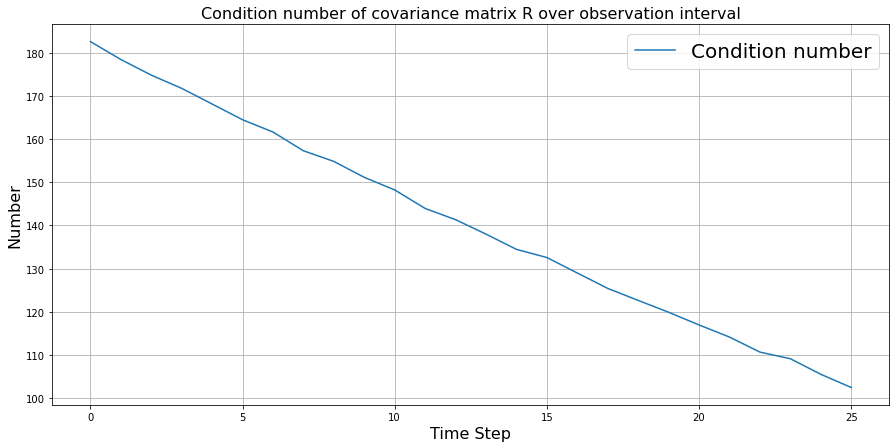

In [51]:
showPlease([condNumbers],
           ['Condition number'], 
           'Time Step', 'Number', 
           'Condition number of covariance matrix R over observation interval');

**Condition numbers of covariance matrix R vary from 100 to 180 units over the observational time. Their values are much greater than 1 which indicates that matrix R is ill-conditioned.**

# 13


**At this point, we will analyze how filter gain K depends on time:**

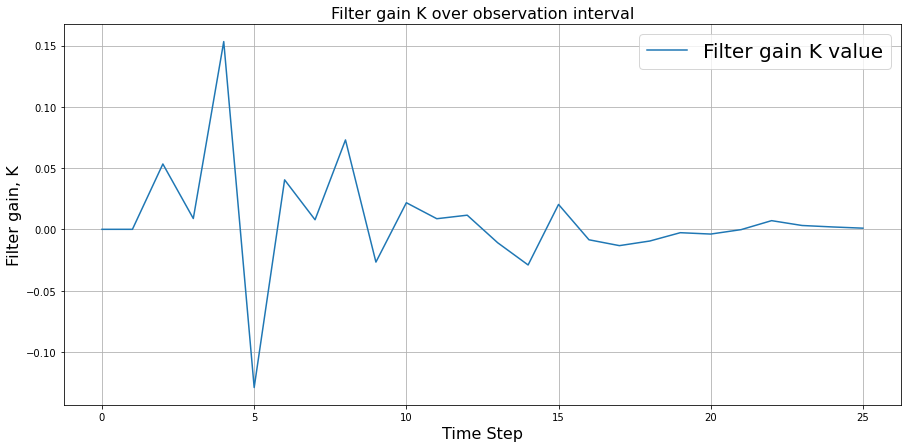

In [52]:
gainK = [x.item(1,1) for x in kalman.listK]
showPlease([gainK],
           ['Filter gain K value'], 
           'Time Step', 'Filter gain, K', 
           'Filter gain K over observation interval');

**During the first 15 time steps, filter gain K values noticeably fluctuate and even turn negative. Although these values should belong to the interval (0,1), we consider a nonlinear system where optimal conditions (0,1) are not applicable. This is related to the fact that matrix R depends on polar measurements that have errors. Overall, by the end of the time interval under study, the figures are stabilizing about zero.**

# 14


**Now let us consider a different case when an object starts its motion at a quite close distance from an observer. The initial coordinates are now changed:**

In [54]:
data_14 = copy.deepcopy(data)
data_14.initialVectorX = np.matrix([[3500/2**0.5],[-50],[3500/2**0.5],[-45]])
kalman_14 = createProcessGiveKalman(data_14)
D_15,Ang_15 = manyKalman(data_14)

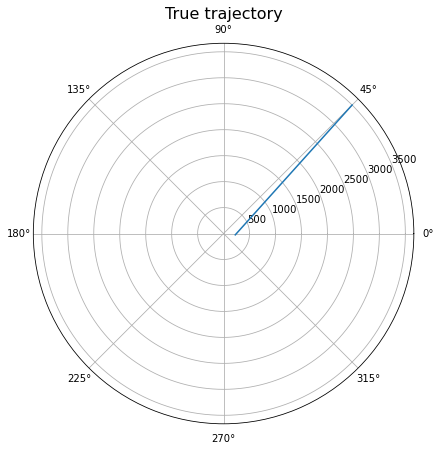

In [62]:
D_14 = giveElements(data_14.trueProcessPol,0)
ang_14 = giveElements(data_14.trueProcessPol,1)


plt.figure(figsize=(7,7))
plt.polar(ang_14,D_14)
plt.title('True trajectory', fontsize = 16);

**Now we see that an object is indeed closer to an observer at the start of its motion than in the previous case.**

# 15

**True estimation errors of extrapolated and filtrated estimates of range and azimuth are plotted again for comparison:**

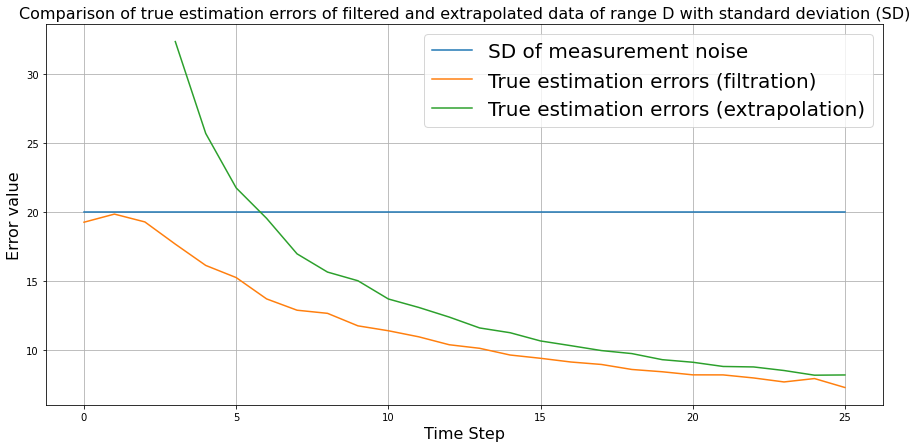

In [63]:
sigmaList = [data.externalNoiseSigma[0] for i in range(0,data.size)]
showPlease([sigmaList,D_15[0],D_15[1][3:]],
           ['SD of measurement noise', 
            'True estimation errors (filtration)', 
            'True estimation errors (extrapolation)'], 
            'Time Step', 'Error value', 
            'Comparison of true estimation errors of filtered and extrapolated data of range D with standard deviation (SD)');

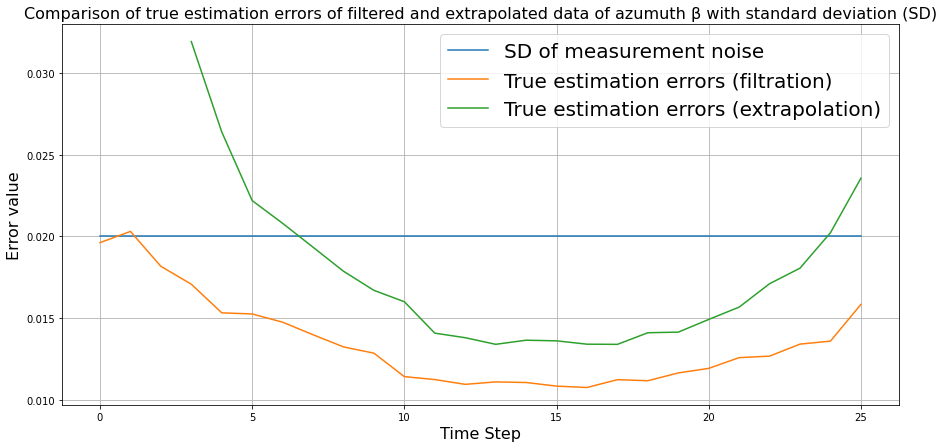

In [65]:
showPlease([sigmaListAng,Ang_15[0],Ang_15[1][3:]],
           ['SD of measurement noise', 
            'True estimation errors (filtration)', 
            'True estimation errors (extrapolation)'], 
            'Time Step', 'Error value', 
            'Comparison of true estimation errors of filtered and extrapolated data of azumuth β with standard deviation (SD)');

**For true estimation errors of range D, we observe a gradual decrease of the values over observation interval as we did previous time when the start of the object's motion was quite far away from an observer, but for azimuth angle β the trend has changed — now we see that the values of true errors for both extrapolation and filtration are slightly decreasing over the period of approximately 15 time steps, but then they start increasing again. Let us have a closer look on how the situation has changed by plotting again the values of errors obtained during the previous case and now:**

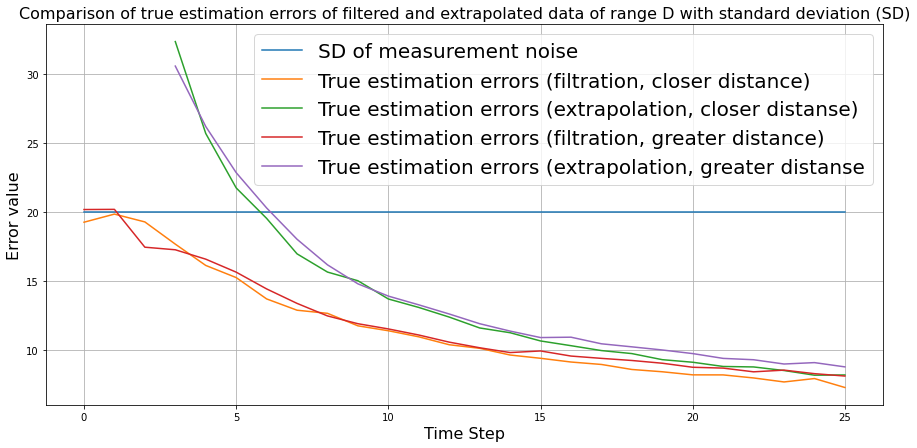

In [70]:
showPlease([sigmaList,D_15[0],D_15[1][3:],D_10[0],D_10[1][3:]],
           ['SD of measurement noise', 
            'True estimation errors (filtration, closer distance)', 
            'True estimation errors (extrapolation, closer distanse)',
            'True estimation errors (filtration, greater distance)', 
            'True estimation errors (extrapolation, greater distanse'], 
            'Time Step', 'Error value', 
            'Comparison of true estimation errors of filtered and extrapolated data of range D with standard deviation (SD)');

**From the graph, it looks like true estimation errors of the case with a greater distance between the start of the object's motion and observer have not changed when we put the start of the motion closer to the observer. Thus, we can assume that both filtered and extrapolated estimates of range D are not so sensitive to the change of the initial coordinates.**

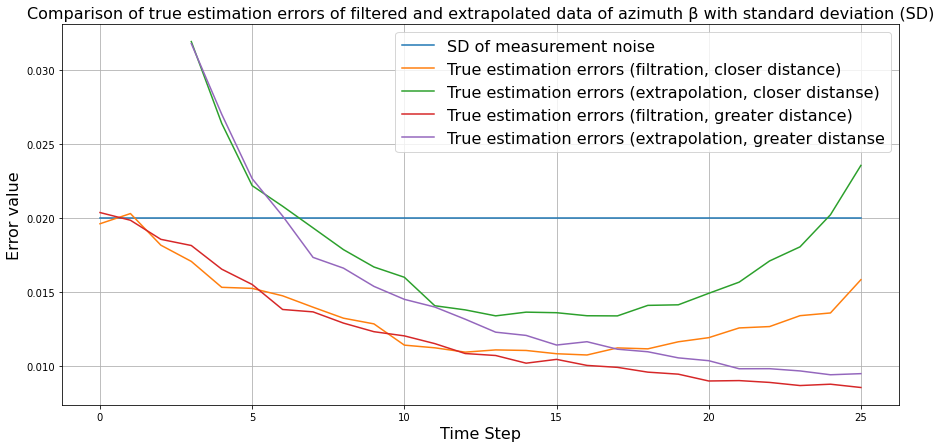

In [83]:
showPlease([sigmaListAng,Ang_15[0],Ang_15[1][3:],Ang_10[0],Ang_10[1][3:]],
           ['SD of measurement noise', 
            'True estimation errors (filtration, closer distance)', 
            'True estimation errors (extrapolation, closer distanse)',
            'True estimation errors (filtration, greater distance)', 
            'True estimation errors (extrapolation, greater distanse'], 
            'Time Step', 'Error value', 
            'Comparison of true estimation errors of filtered and extrapolated data of azimuth β with standard deviation (SD)');

**However, for azimuth angle β, we see that true errors of filtered and extrapolated estimates in the case of a closer distance start increasing by the end of the time interval under study, while the figures for the previous case keep decreasing.**

**As we did before, let us see the dependence of coordinate X and azimuth angle β then:**

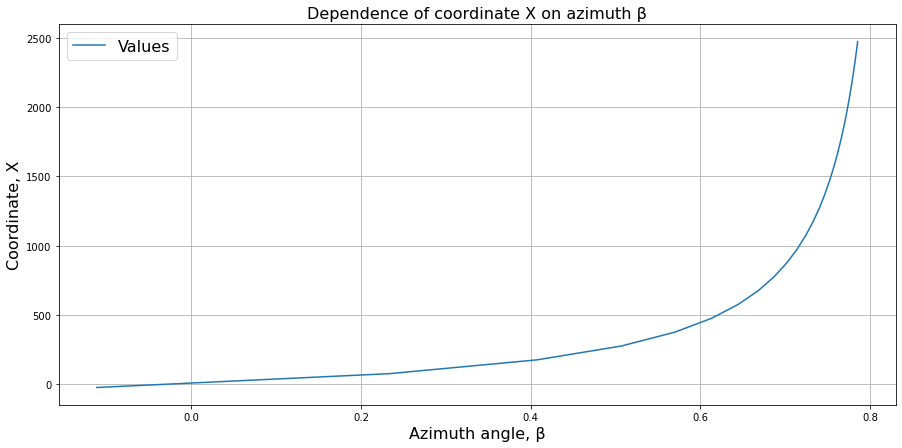

In [72]:
x_15 = giveElements(data_14.trueProcess,0)
ang_15 = giveElements(data_14.trueProcessPol,1)

plt.figure(figsize=(15,7))
plt.grid()
plt.xlabel('Azimuth angle, β', fontsize = 16)
plt.ylabel('Coordinate, X', fontsize = 16)
plt.title('Dependence of coordinate X on azimuth β', fontsize = 16)
plt.plot(ang_15,x_15)
plt.legend(['Values'], fontsize = 16);

**In comparison to the previous case, we clearly observe non-linear dependence there. Thus, linearization errors are now significant.**

# 17

**Condition numbers of covariance matrix R over time interval for these new initial conditions are of interest now:**

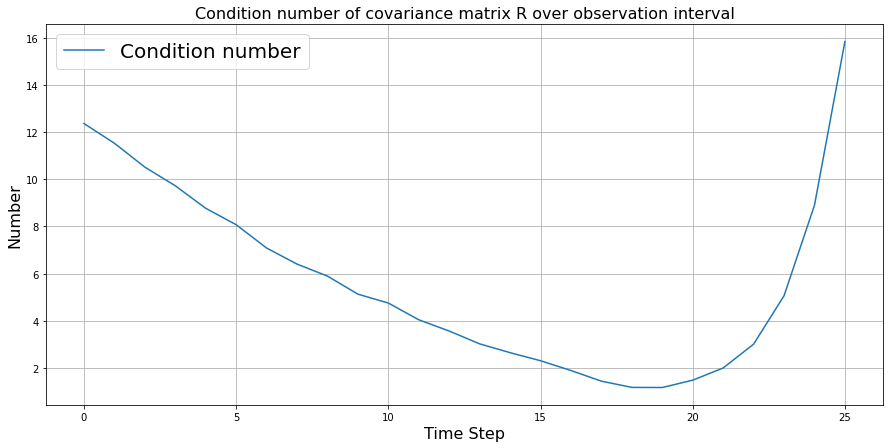

In [73]:
condNumbers2 = [np.linalg.cond(x) for x in data_14.listR]
showPlease([condNumbers2],
           ['Condition number'], 
           'Time Step', 'Number', 
           'Condition number of covariance matrix R over observation interval');

**Before we observed an almost-linear decrease of condition numbers over time, but now the trend has changed showing us a dramatical rise after the 20th time step. Moreover, the range of values has changed as well — now the numbers vary between 1 and 16 units. In this case, condition number approaches 1 meaning that matrix R is well-conditioned in comparison with the previous case.**

# 18

**By comparison of two cases, it was assumed that great linearization errors, gained during the case with a closer distance between the start of an object's motion and an observer, affect tracking accuracy as true estimation errors of both extrapolated and filtrated estimates of azimuth angle β start increasing by the end of time interval under study as well as condition number turing the matrix R from well-conditioned to ill-conditioned. Thus, farther starting position of a moving object is important to obtain higher tracking accuracy.**

# 19

**Let us run filter again over M = 500 runs using new initial conditions to generate a trajectory when an object starts its motion at a quite close distance from an observer, BUT! This time, in order to generate polar measurements, we will use other values of variances of measurement noises — a bigger one for range D and a smaller one for azimuth angle β:**

In [74]:
data_19 = copy.deepcopy(data_14)
newSigmaD = 50
newSigmaAng = 0.0015
data_19.externalNoiseSigma = [newSigmaD,newSigmaAng]
D_19,Ang_19 = manyKalman(data_19)

# 19.15


**Let us see how it influences all the steps we did for both previous cases:**

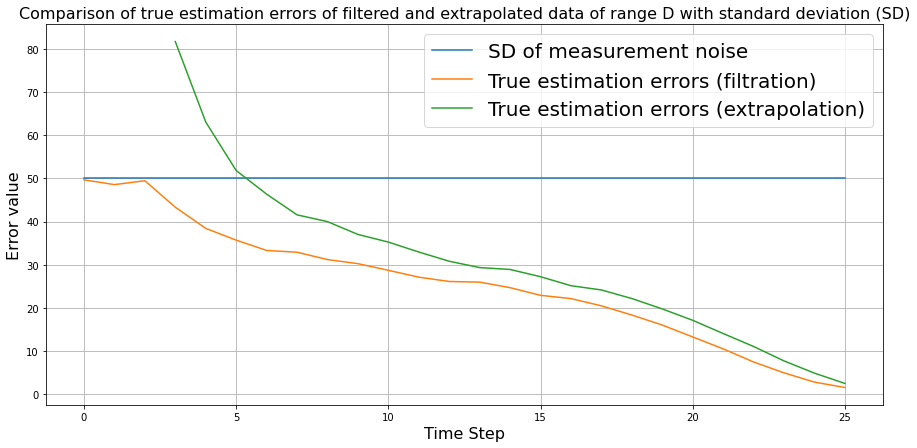

In [75]:
sigmasD_19v14 = [newSigmaD for i in range(data_19.size)] 
showPlease([sigmasD_19v14,D_19[0],D_19[1][3:]],
           ['SD of measurement noise', 
            'True estimation errors (filtration)', 
            'True estimation errors (extrapolation)'], 
            'Time Step', 'Error value', 
            'Comparison of true estimation errors of filtered and extrapolated data of range D with standard deviation (SD)');

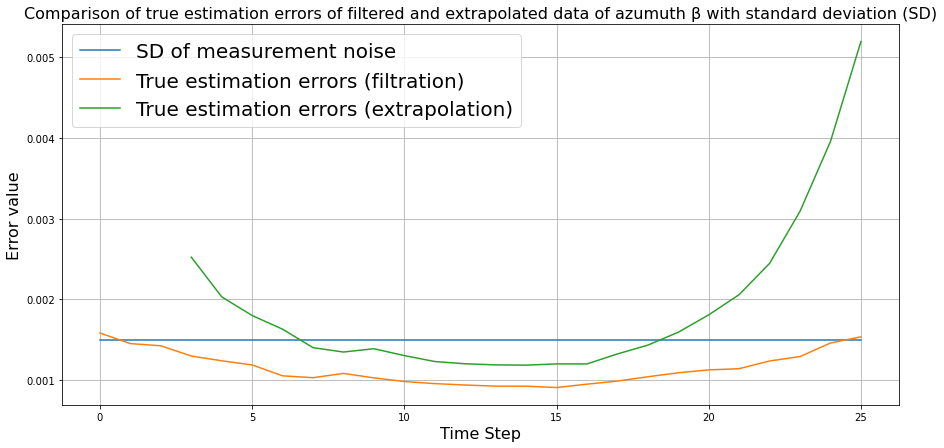

In [76]:
sigmasAng_19v14 = [newSigmaAng for i in range(data_19.size)] 
showPlease([sigmasAng_19v14,Ang_19[0],Ang_19[1][3:]],
           ['SD of measurement noise', 
            'True estimation errors (filtration)', 
            'True estimation errors (extrapolation)'], 
            'Time Step', 'Error value', 
            'Comparison of true estimation errors of filtered and extrapolated data of azumuth β with standard deviation (SD)');

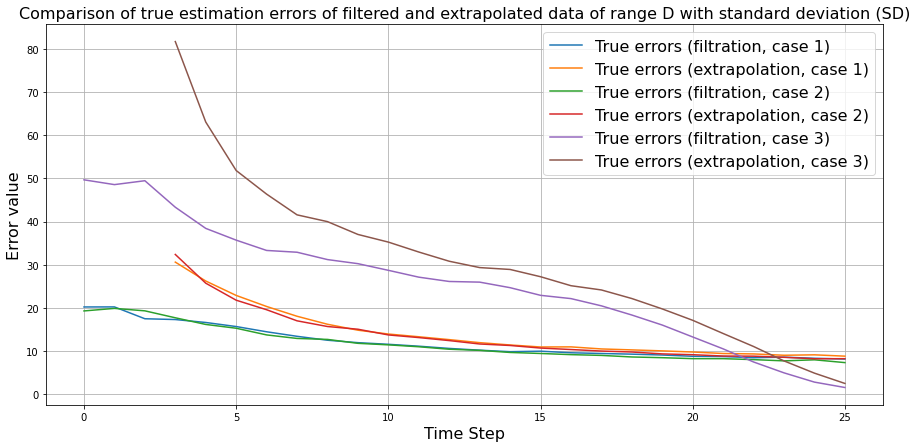

In [84]:
showPlease([D_10[0],D_10[1][3:],D_15[0],D_15[1][3:],D_19[0],D_19[1][3:]],
           ['True errors (filtration, case 1)', 
            'True errors (extrapolation, case 1)',
            'True errors (filtration, case 2)', 
            'True errors (extrapolation, case 2)',
            'True errors (filtration, case 3)', 
            'True errors (extrapolation, case 3)'], 
            'Time Step', 'Error value', 
            'Comparison of true estimation errors of filtered and extrapolated data of range D with standard deviation (SD)');

**The last case provided us with a new trend: true errors of range D were much larger than for the previous cases over almost the whole time period, but then, after the ~22th time step, the figures for these errors turned out to be smaller continuing to decrease almost to zero. Thus, an increase of measurement noise variance for range D firstly affected dramatically the errors of estimation, but with an increasing distance of the object from an observer, the errors kept decreasing resulted in a better accuracy of traking by the end of time interval under study than for the other two cases.**

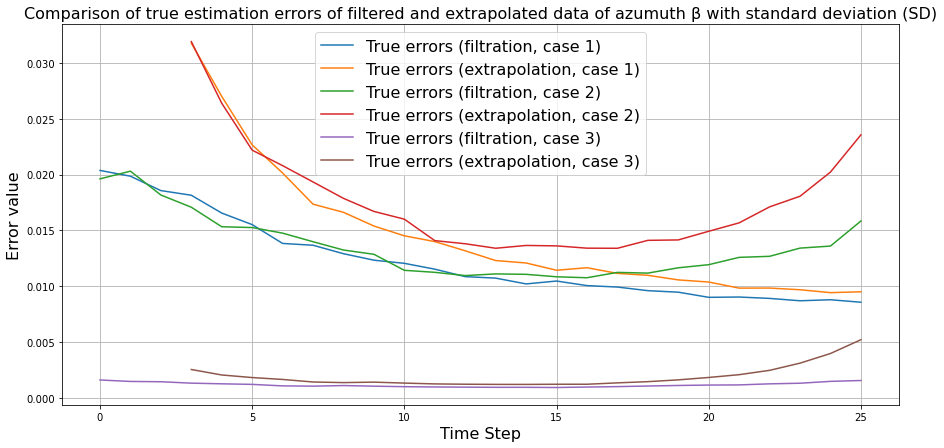

In [85]:
showPlease([Ang_10[0],Ang_10[1][3:], Ang_15[0], Ang_15[1][3:],Ang_19[0],Ang_19[1][3:]],
           ['True errors (filtration, case 1)', 
            'True errors (extrapolation, case 1)',
            'True errors (filtration, case 2)', 
            'True errors (extrapolation, case 2)',
            'True errors (filtration, case 3)', 
            'True errors (extrapolation, case 3)'], 
            'Time Step', 'Error value', 
            'Comparison of true estimation errors of filtered and extrapolated data of azumuth β with standard deviation (SD)');

**Smaller value of measurement noise variance for azimuth angle β resulted in a noticeable drop of the error values making the tracking more accurate, however, a slight increase of errors by the end of time period is observed again in comparison with the case where starting point is located further.**

# 19.16

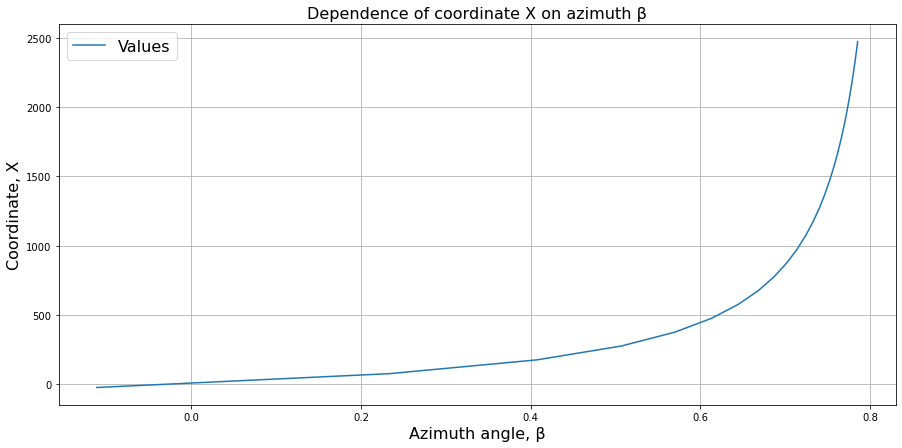

In [87]:
x_19v16 = giveElements(data_19.trueProcess,0)
ang_19v16 = giveElements(data_19.trueProcessPol,1)

plt.figure(figsize=(15,7))
plt.grid()
plt.xlabel('Azimuth angle, β', fontsize = 16)
plt.ylabel('Coordinate, X', fontsize = 16)
plt.title('Dependence of coordinate X on azimuth β', fontsize = 16)
plt.plot(ang_19v16,x_19v16)
plt.legend(['Values'], fontsize = 16);

**As for the dependence of coordinate on azimuth angle, it looks absolutely the same as in the second case. It is obvious because the true trajectory has not changed when the value of measurement noise variance has changed.**

# 19.17

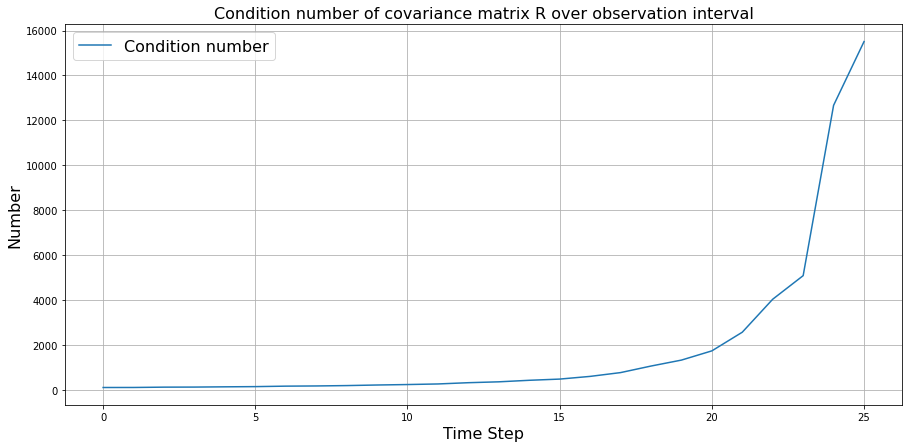

In [90]:
condNumbers_19 = [np.linalg.cond(x) for x in data_19.listR]
showPlease([condNumbers_19],
           ['Condition number'], 
           'Time Step', 'Number', 
           'Condition number of covariance matrix R over observation interval');

**The condition number values have experienced significant changes — from the very beginning, condition number was high (~100) increasing sharply to extremely high values. Therefore, it is obvious that the matrix R is ill-conditioned which makes the filter diverge.**